# Multistep Forecasting Recursive

## Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

import xgboost

## Load Data

In [2]:
# load dataset
data = pd.read_csv("portfolio_data.csv")

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(1520, 5)


,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285


In [3]:
data.Date = pd.to_datetime(data.Date)

In [4]:
data = data.set_index("Date")

In [5]:
AMZN_df = data[["AMZN"]].rename(columns={"AMZN":"price"})
DPZ_df = data[["DPZ"]].rename(columns={"DPZ":"price"})
BTC_df = data[["BTC"]].rename(columns={"BTC":"price"})
NFLX_df = data[["NFLX"]].rename(columns={"NFLX":"price"})

## Feature Engineering

In [6]:
# Datetime features

dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",

    # the features we want to create
    features_to_extract=[
        "month",
        "day_of_week",
        "day_of_month",
    ],
)

In [7]:
# Lag features.

lagf = LagFeatures(
    variables=["price"],  # the input variables
    periods=[1, 5, 21],  # move 1 day, 1 week and 1 month forward
    missing_values="ignore",
)

In [8]:
# Window features

winf = WindowFeatures(
    variables=["price"],  # the input variables
    window=[5, 21],  # average of previous week and previous month
    freq="1D",  # move 1 day forward
    missing_values="ignore",
)

In [9]:
# Periodic features

cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["day_of_week", "day_of_month", "month"],
    # Whether to drop the original features.
    drop_original=True,
)

In [10]:
# Drop missing data

imputer = DropMissingData()

In [11]:
# Drop original time series

drop_ts = DropFeatures(features_to_drop=["price"])

## Feature engineering pipeline

In [12]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

# Split data into train and test

We will leave the last week of data as hold-out sample to evaluate the performance of the model.

we need data about the stock information at least 1 month before the first forecasting point in the test set to create the input features.

In [13]:
# Split the data.

# input data
X_train_AMZN = AMZN_df[AMZN_df.index < "2019-05-07"]
X_test_AMZN = AMZN_df[AMZN_df.index >= pd.Timestamp("2019-05-07") - pd.DateOffset(days=32)]

# target
y_train_AMZN = AMZN_df[AMZN_df.index < "2019-05-07"][["price"]]
y_test_AMZN = AMZN_df[AMZN_df.index >= pd.Timestamp("2019-05-07") - pd.DateOffset(days=32)][["price"]]

## Train pipeline and model

Train the engineering steps and the pipeline utilizing the training set.

In [14]:
# Train the pipeline and create features
# for the train set:

X_train_t_AMZN = pipe.fit_transform(X_train_AMZN)

# Data with input features.
X_train_t_AMZN.head()

,price_lag_1,price_lag_5,price_lag_21,price_window_5_mean,price_window_21_mean,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos
Date,,,,,,,,,,,
2013-05-31,266.829987,261.799988,248.229996,264.637995,262.419521,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,5.000000e-01,-0.866025
2013-06-04,266.880005,267.290009,258.049988,267.146002,264.100474,1.000000e+00,6.123234e-17,7.247928e-01,0.688967,1.224647e-16,-1.000000
2013-06-05,265.700012,265.529999,255.720001,266.828003,264.464761,1.224647e-16,-1.000000e+00,8.486443e-01,0.528964,1.224647e-16,-1.000000
2013-06-06,267.170013,266.829987,257.730011,267.156006,265.010000,-1.000000e+00,-1.836970e-16,9.377521e-01,0.347305,1.224647e-16,-1.000000
2013-06-07,267.829987,269.200012,258.679993,267.356006,265.490951,-2.449294e-16,1.000000e+00,9.884683e-01,0.151428,1.224647e-16,-1.000000


In [15]:
# The transformation pipeline removed observations
# with missing data, so its necesary to remove those
# observations from the target variable as well.

print(y_train_AMZN.shape)

y_train_t_AMZN = y_train_AMZN.loc[X_train_t_AMZN.index]

print(y_train_t_AMZN.shape)

(1514, 1)
(1167, 1)


In [16]:
# Lasso regression

lasso_AMZN = Lasso(random_state=0)

# Train the model

lasso_AMZN.fit(X_train_t_AMZN, y_train_t_AMZN)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e+05, tolerance: 3.085e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(random_state=0)

# Forecasting 5 days forward - step by step

First, obtain a forecast for the first 5 days in the test set.

In [17]:
# The first day of forecast.
forecast_point = pd.Timestamp("2019-05-07")

# The forecasting horizon (5 days ahead)
forecast_end = forecast_point + pd.offsets.Day(7)

# The timestamps at which we want to predict

index = pd.date_range(
    start=forecast_point,
    end=forecast_end,
    freq="1D",
)

# the forecasting horizon
f_horizon = pd.DataFrame(columns=["price"], index=index)

f_horizon

,price
2019-05-07,NaN
2019-05-08,NaN
2019-05-09,NaN
2019-05-10,NaN
2019-05-11,NaN
2019-05-12,NaN
2019-05-13,NaN
2019-05-14,NaN


In [18]:
# Obtain the input data for the predictions

# The first day of forecast.
forecast_point = pd.Timestamp("2019-05-07")

# 1 month before the first forecasting point
start_point = forecast_point - pd.DateOffset(days=32)

# Create input data to obtain the first prediction value.
input_data = X_test_AMZN[(X_test_AMZN.index >= start_point) & (X_test_AMZN.index < forecast_point)]
input_data.loc[forecast_point] = np.nan

<ipython-input-18-5aacbb9a315b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[forecast_point] = np.nan


In [19]:
# Let's obtain the first prediction.

pred = lasso_AMZN.predict(pipe.transform(input_data))[0]

In [20]:
# Add the prediction to the horizon
# and to the input data

f_horizon.loc[forecast_point] = pred
input_data.loc[forecast_point] = pred

<ipython-input-20-bfb1073e7b81>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[forecast_point] = pred


In [21]:
# And we repeat the process 23 times:

for i in range(7):

    # Re-slice the input data
    start_point = start_point + pd.DateOffset(days=1)
    forecast_point = forecast_point + pd.DateOffset(days=1)

    input_data = input_data[(input_data.index >= start_point)]
    input_data.loc[forecast_point] = np.nan

    # Obtain the prediction
    pred = lasso_AMZN.predict(pipe.transform(input_data))

    # Add prediction to horizon.
    f_horizon.loc[forecast_point] = pred[-1]
    input_data.loc[forecast_point] = pred[-1]

f_horizon

,price
2019-05-07,1951.086392
2019-05-08,1951.122642
2019-05-09,1951.056854
2019-05-10,1953.571108
2019-05-11,1955.505254
2019-05-12,1957.423897
2019-05-13,1959.301708
2019-05-14,1961.058127


In [22]:
# We can plot our predictions vs. the truth, which is
# the stock price in the test set.

tmp = pd.DataFrame(f_horizon["price"]).join(
    X_test_AMZN["price"], lsuffix="_left", rsuffix="_right")

tmp.columns = ["predicted", "actual"]

tmp = tmp.dropna()

tmp

,predicted,actual
2019-05-07,1951.086392,1921.000000
2019-05-08,1951.122642,1917.770020
2019-05-09,1951.056854,1899.869995
2019-05-10,1953.571108,1889.979980
2019-05-13,1959.301708,1822.680054
2019-05-14,1961.058127,1840.119995


Text(0, 0.5, 'stock price')

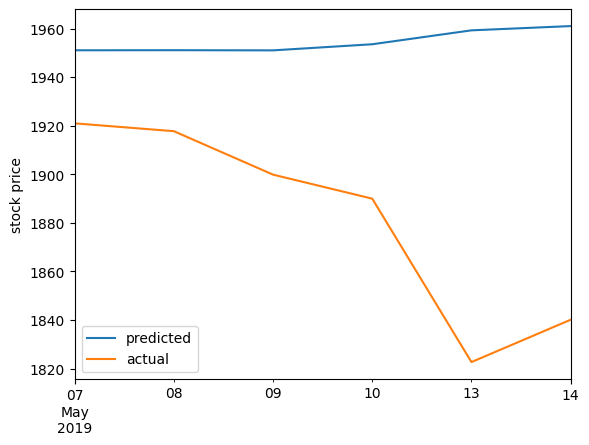

In [23]:
tmp.plot()
plt.ylabel("stock price")

In [24]:
r2_score(tmp["actual"],tmp["predicted"])

-3.96355277896238

Text(0, 0.5, 'Importance')

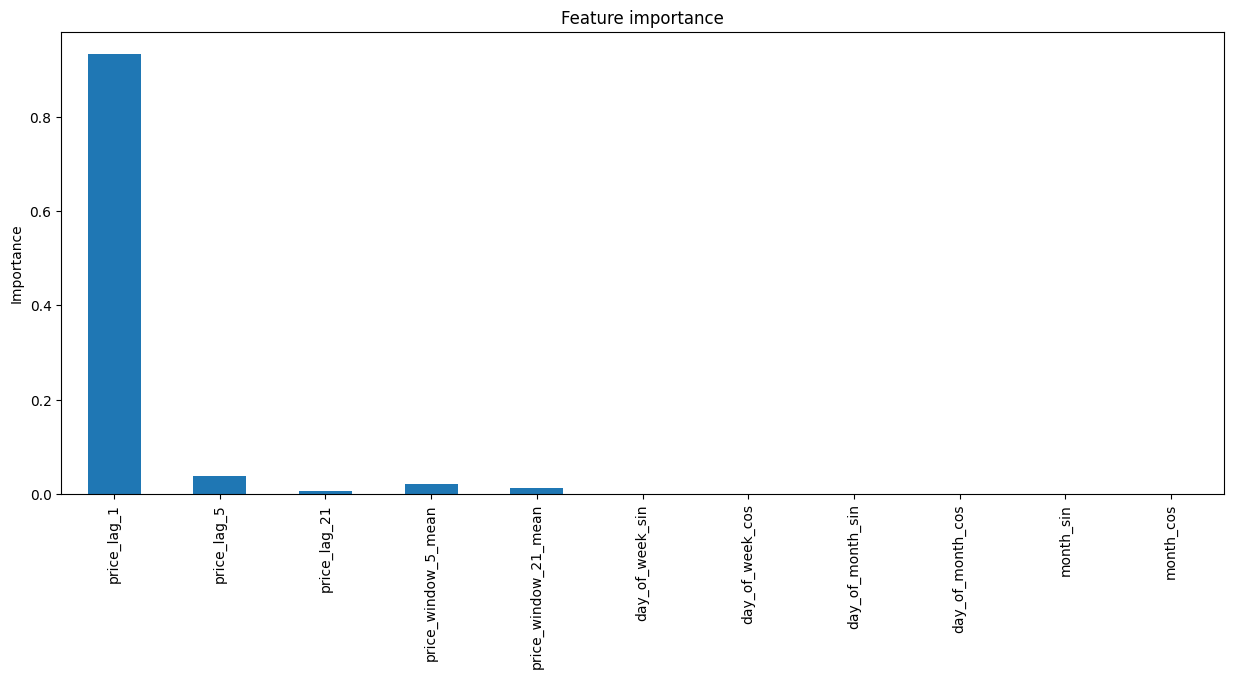

In [25]:
# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp = pd.Series(np.abs(lasso_AMZN.coef_))

# Let's add the variable names.
tmp.index = X_train_t_AMZN.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")

## XGBoost

In [26]:
# Lasso regression

xgbr_AMZN = xgboost.XGBRegressor()

# Train the model

xgbr_AMZN.fit(X_train_t_AMZN, y_train_t_AMZN)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [27]:
# The first day of forecast.
forecast_point = pd.Timestamp("2019-05-07")

# The forecasting horizon (5 days ahead)
forecast_end = forecast_point + pd.offsets.Day(7)

# The timestamps at which we want to predict

index = pd.date_range(
    start=forecast_point,
    end=forecast_end,
    freq="1D",
)

# the forecasting horizon
f_horizon = pd.DataFrame(columns=["price"], index=index)

f_horizon

,price
2019-05-07,NaN
2019-05-08,NaN
2019-05-09,NaN
2019-05-10,NaN
2019-05-11,NaN
2019-05-12,NaN
2019-05-13,NaN
2019-05-14,NaN


In [28]:
# Obtain the input data for the predictions

# The first day of forecast.
forecast_point = pd.Timestamp("2019-05-07")

# 1 month before the first forecasting point
start_point = forecast_point - pd.DateOffset(days=32)

# Create input data to obtain the first prediction value.
input_data = X_test_AMZN[(X_test_AMZN.index >= start_point) & (X_test_AMZN.index < forecast_point)]
input_data.loc[forecast_point] = np.nan

<ipython-input-28-5aacbb9a315b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[forecast_point] = np.nan


In [29]:
# Let's obtain the first prediction.

pred = xgbr_AMZN.predict(pipe.transform(input_data))[0]

In [30]:
# Add the prediction to the horizon
# and to the input data

f_horizon.loc[forecast_point] = pred
input_data.loc[forecast_point] = pred

<ipython-input-30-bfb1073e7b81>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[forecast_point] = pred


In [31]:
# And we repeat the process 23 times:

for i in range(7):

    # Re-slice the input data
    start_point = start_point + pd.DateOffset(days=1)
    forecast_point = forecast_point + pd.DateOffset(days=1)

    input_data = input_data[(input_data.index >= start_point)]
    input_data.loc[forecast_point] = np.nan

    # Obtain the prediction
    pred = xgbr_AMZN.predict(pipe.transform(input_data))

    # Add prediction to horizon.
    f_horizon.loc[forecast_point] = pred[-1]
    input_data.loc[forecast_point] = pred[-1]

f_horizon

,price
2019-05-07,1960.595703
2019-05-08,1965.145508
2019-05-09,1947.824341
2019-05-10,1959.199097
2019-05-11,1972.986816
2019-05-12,1963.582031
2019-05-13,1971.03894
2019-05-14,1961.646362


In [32]:
# We can plot our predictions vs. the truth, which is
# the stock price in the test set.

tmp = pd.DataFrame(f_horizon["price"]).join(
    X_test_AMZN["price"], lsuffix="_left", rsuffix="_right")

tmp.columns = ["predicted", "actual"]

tmp = tmp.dropna()

tmp

,predicted,actual
2019-05-07,1960.595703,1921.000000
2019-05-08,1965.145508,1917.770020
2019-05-09,1947.824341,1899.869995
2019-05-10,1959.199097,1889.979980
2019-05-13,1971.03894,1822.680054
2019-05-14,1961.646362,1840.119995


Text(0, 0.5, 'stock price')

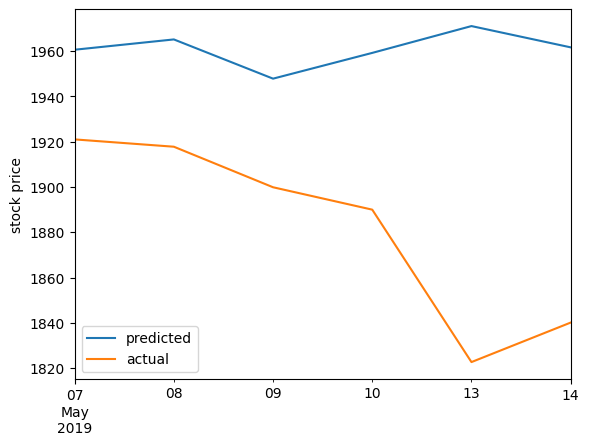

In [33]:
tmp.plot()
plt.ylabel("stock price")

In [34]:
r2_score(tmp["actual"],tmp["predicted"])

-4.638693543045253

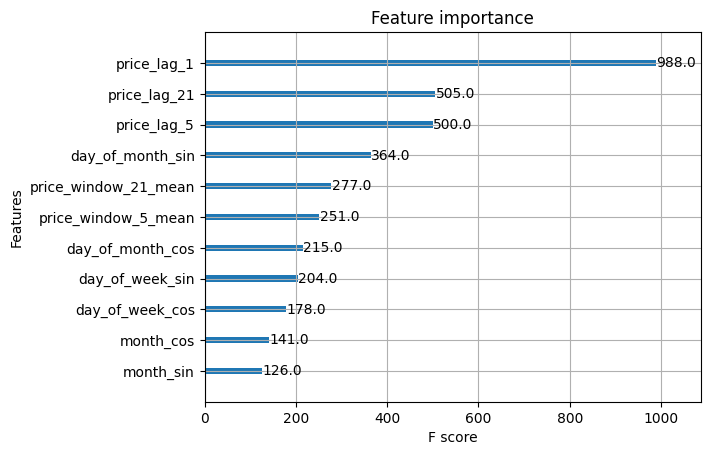

In [35]:
xgboost.plot_importance(xgbr_AMZN, importance_type='weight')

plt.show()